In [1]:
import numpy as np 
import scipy.special
import matplotlib.pyplot as plt

# Generic functions

## Generic run function

In [2]:
def run(tf,dt,gamma):
    ''' Returns a trajectory of a constrained run-and-tumble particle during a time tf with
    time increments dt with a given effective tumbling rate gamma '''
    x = 0
    positions = [x]
    t = 0
    times = [t]
    sigma = 1
    
    while t < tf:
        
        if np.random.rand() < gamma(x,t,tf)**sigma*dt:
            sigma = - sigma
            positions.append(x)
            times.append(t)
        
        x += sigma * dt    
        t += dt 
    
    positions.append(x)
    times.append(t)
    return times, positions


''' functions f, g and h defined in the paper'''
def f(t,x):
    return t - x
def g(t,x):
    return t + x
def h(t,x):
    return np.sqrt(f(t,x)*g(t,x))

# Bridge run-and-tumble trajectories

In [3]:
def gamma_bridge(x,t,tf):
    ''' returns the effective tumbling rate a bridge run-and-tumble particle with
    \sigma_0 = +1 and \sigma_f = -1'''
    tau = tf-t
    if np.abs(f(tau,x))<0.01:
        return np.inf
    else:   
        return np.sqrt(g(tau,x)/f(tau,x)) * scipy.special.i1(h(tau,x))/scipy.special.i0(h(tau,x))

In [4]:
dt = 0.01
tf = 5
times, positions = run(tf,dt,gamma_bridge)

Text(0, 0.5, 'x')

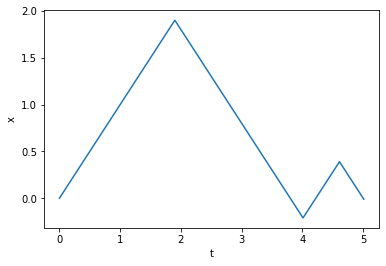

In [5]:
plt.plot(times,positions)
plt.xlabel('t')
plt.ylabel('x')

# Excursion run-and-tumble trajectories

In [6]:
def gamma_excursion(x,t,tf):
    ''' returns the effective tumbling rate an excursion run-and-tumble particle'''
    tau = tf-t
    if np.abs(f(tau,x))<0.01:
        return np.inf
    else:
        numerator = scipy.special.i1(h(tau,x))
        denominator = x*scipy.special.i0(h(tau,x))+np.sqrt(f(tau,x)/g(tau,x))*scipy.special.i1(h(tau,x))
        return x*np.sqrt(g(tau,x)/f(tau,x))*numerator/denominator

In [7]:
dt = 0.01
tf = 5
times, positions = run(tf,dt,gamma_excursion)

Text(0, 0.5, 'x')

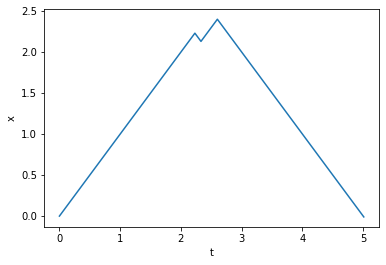

In [8]:
plt.plot(times,positions)
plt.xlabel('t')
plt.ylabel('x')

# Meander run-and-tumble trajectory

In [9]:
''' First-passage distribution and survival probability of a free particle 
in the presence of an absorbing boundary at the origin. These functions are
necessary to compute the effective tumbling rate for the meander run-and-tumble
trajectory.
'''
def F_plus(x,t):
    return np.exp(-t)/g(t,x)*(x*scipy.special.i1(h(t,x)) + np.sqrt(f(t,x)/g(t,x))*scipy.special.i1(h(t,x)))
def F_minus(x,t):
    return np.exp(-t)*x/np.sqrt(h(t,x))*scipy.special.i1(h(t,x))
def S_plus(x,t,dt):
    times = np.arange(x+dt,tf-t,dt)
    return 1 - np.trapz(F_plus(x,times),times)
def S_minus(x,t,dt):
    times = np.arange(x+dt,tf-t,dt)
    delta_contrib = np.exp(-x)
    return 1 - delta_contrib - np.trapz(F_minus(x,times),times)

In [10]:
''' We cache the values of the effective tumbling rate in memory for 
better efficiency because its exact expression is known as an integral 
representation. Cache is a dictionary indexed by the times and whose values 
are the effective tumbling rates at various positions.
'''
def create_cache_gamma(tf,dt):
    
    cache = {}
    t = 0
    while t < tf:
        positions = np.arange(0,tf/2 - np.abs(t-tf/2) + dt,dt)
        gamma_values = np.zeros(len(positions)) 
        for i in range(len(positions)):
            x = positions[i]
            gamma_values[i] = S_minus(x,t,dt)/S_plus(x,t,dt)
            
        cache[t] = {'x':positions,'gamma':gamma_values}
        t = t + dt
    return cache

In [11]:
def gamma_meander(x,t,tf):
    ''' returns the effective tumbling rate a meander run-and-tumble particle'''
    if x <= tf/2 - np.abs(t-tf/2):
        return np.interp(x,cache[t]['x'],cache[t]['gamma'])
    else:
        return 1

In [12]:
dt = 0.1
tf = 5
cache = create_cache_gamma(tf,dt)
times, positions = run(tf,dt,gamma_meander)

Text(0, 0.5, 'x')

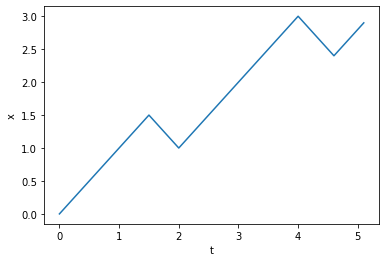

In [13]:
plt.plot(times,positions)
plt.xlabel('t')
plt.ylabel('x')